In [1]:
#Final CODE PARALLEL
import numpy as np
from numpy.linalg import eigh
import time
import matplotlib.pyplot as plt
import math
import pyspark
from pyspark import SparkContext
from pyspark.mllib.linalg import Matrices
from pyspark.mllib.linalg.distributed import BlockMatrix
from scipy import stats


def create_block_matrix_from_numpy(
    np_array: np.ndarray,
    row_block_count: int,
    col_block_count: int,
    sc
    ):
    """
    Create a BlockMatrix from a NumPy array.
    
    Args:
        np_array (np.ndarray): NumPy array to be converted
        row_block_count (int): Number of rows in each block
        col_block_count (int): Number of columns in each block
        sc: SparkContext for parallelization
        
    Returns:
        BlockMatrix: Distributed block matrix representation of input array
    """
    num_rows: int = 0
    num_cols: int = 0
    blocks: list = []
    blocks_rdd: pyspark.RDD = None
    block_dense_matrix: Matrices.dense = None
    
    num_rows, num_cols = np_array.shape

    for j in range(0, num_cols, col_block_count):
        for i in range(0, num_rows, row_block_count):
            block = np_array[i:i + row_block_count, j:j + col_block_count]
            block_dense_matrix = Matrices.dense(block.shape[0], block.shape[1], block.T.flatten())
            blocks.append(((i // row_block_count, j // col_block_count), block_dense_matrix))

    blocks_rdd = sc.parallelize(blocks)
    
    return BlockMatrix(blocks_rdd, row_block_count, col_block_count)
    
def svd(
    gram_mat: pyspark.mllib.linalg.distributed.BlockMatrix,
    row_block_count: int,
    col_block_count: int,
    sc
    ):
    """
    Perform Singular Value Decomposition (SVD) on a Gramian matrix.
    
    Args:
        gram_mat (BlockMatrix): The input Gramian matrix.
        row_block_count (int): Number of rows in each block
        col_block_count (int): Number of columns in each block
    
    Returns:
        tuple[BlockMatrix, BlockMatrix, BlockMatrix]: The U, Sigma-inverse, and V^T matrices as BlockMatrices.
    """
    matrix_size: int = 0
    tol: float = 0.0
    arr: np.ndarray = None
    eigval_V: np.ndarray = None
    eigvecs: np.ndarray = None
    idx: np.ndarray = None
    eigvals_inv: np.ndarray = None
    block_s_inv: BlockMatrix = None
    block_v: BlockMatrix = None
    
    tol = 1e-15

    # Compute and sort eigenvalues and eigenvectors with a numpy Array.
    arr = gram_mat.toLocalMatrix().toArray()
    eigval_V, eigvecs = np.linalg.eigh(arr)
    idx = eigval_V.argsort()[::-1]
    eigval_V = eigval_V[idx]
    eigvecs = eigvecs[:, idx]

    # Invert eigenvalues (set small ones to zero) and form a diagonal matrix.
    eigvals_inv = np.array([1/val if val > tol else 0 for val in eigval_V])
    eigvals_inv = np.diag(eigvals_inv)
    
    # Convert results to block matrices for Spark and transpose the eigenvectors.
    block_s_inv = create_block_matrix_from_numpy(eigvals_inv, int(math.ceil(eigvals_inv.shape[0]/n_workers)), int(math.ceil(eigvals_inv.shape[1]/n_workers)), sc)

    block_v = create_block_matrix_from_numpy(eigvecs, int(math.ceil(eigvecs.shape[0]/n_workers)), int(math.ceil(eigvecs.shape[1]/n_workers)), sc)
    
    return block_v.multiply(block_s_inv).multiply(block_v.transpose())

def betacalc(
    X: pyspark.mllib.linalg.distributed.BlockMatrix,
    Y: pyspark.mllib.linalg.distributed.BlockMatrix,
    row_block_count: int,
    col_block_count: int,
    sc
    ):
    """
    Calculate the beta values for the input matrices X and Y.
    
    Args:
        X (BlockMatrix): The input feature matrix.
        Y (BlockMatrix): The target values matrix.
        row_block_count (int): Number of rows in each block
        col_block_count (int): Number of columns in each block
    
    Returns:
        np.ndarray: The computed beta values.
    """
    XtX: BlockMatrix = None
    XtX_inv: BlockMatrix = None
    beta: BlockMatrix = None

    # Compute gram-matrix
    XtX = X.transpose().multiply(X)

    # Invert XtX using SVD.
    XtX_inv = svd(XtX, row_block_count, col_block_count, sc)

    # Compute and return betas
    beta = XtX_inv.multiply(X.transpose()).multiply(Y)
    return beta


def calculate_statistics(
    X: pyspark.mllib.linalg.distributed.BlockMatrix,
    Y: pyspark.mllib.linalg.distributed.BlockMatrix,
    row_block_count: int,
    col_block_count: int,
    sc
):
    """
    Compute comprehensive linear model statistics with statsmodels-style output
    
    Args:  
        X (BlockMatrix): The input feature matrix.
        Y (BlockMatrix): The target values matrix.
        row_block_count (int): Number of rows in each block
        col_block_count (int): Number of columns in each block
        sc: Spark context
    Returns:
        float: elapsed_time for calculating betas
        str: Formatted string containing OLS statistics in statsmodels style
    """
    
    # Calculate beta and convert to local
    elapsed_time = 0
    start_time = time.time()
    beta = betacalc(X, Y, row_block_count, col_block_count, sc)
    fitted_values = X.multiply(beta)
    residuals = Y.subtract(fitted_values)
    elapsed_time = elapsed_time + (time.time() - start_time)
    
    # Convert to local arrays for calculations
    fitted_local = fitted_values.toLocalMatrix().toArray()
    residuals_local = residuals.toLocalMatrix().toArray()
    beta_local = beta.toLocalMatrix().toArray()
    X_local = X.toLocalMatrix().toArray()
    Y_local = Y.toLocalMatrix().toArray()
    
    # Basic dimensions
    n = X.numRows()
    k = X.numCols()  
    df_model = k 
    df_resid = n - k
    
    # Residual statistics
    ssr = np.sum(residuals_local ** 2) 
    mse = ssr / df_resid
    
    # Calculate XtX and its inverse for standard errors
    XtX = X.transpose().multiply(X)
    XtX_local = XtX.toLocalMatrix().toArray()
    XtX_inv = np.linalg.inv(XtX_local)
    
    # Standard errors and t-values
    bse = np.sqrt(np.diag(XtX_inv) * mse)
    tvalues = beta_local.flatten() / bse
    pvalues = 2 * (1 - stats.t.cdf(np.abs(tvalues), df_resid))
    
    # Uncentered R-squared statistics
    tss_uncentered = np.sum(Y_local ** 2) 
    r2_uncentered = 1 - (ssr / tss_uncentered)
    adj_r2_uncentered = 1 - (1 - r2_uncentered) * (n / df_resid)
    
    # F-test (uncentered)
    ess = tss_uncentered - ssr  
    fvalue = (ess / df_model) / mse
    fpvalue = stats.f.sf(fvalue, df_model, df_resid)
    
    # Log-likelihood and information criteria
    llf = -n/2 * (1 + np.log(2*np.pi) + np.log(ssr/n))
    aic = -2 * llf + 2 * k
    bic = -2 * llf + np.log(n) * k
    
    # Additional diagnostics
    condition_number = np.sqrt(np.max(np.linalg.eigvals(XtX_local)) / 
                             np.min(np.linalg.eigvals(XtX_local)))
    
    # Residual diagnostics with corrected Jarque-Bera test
    residuals_standardized = residuals_local.flatten() / np.sqrt(mse)
    skew = stats.skew(residuals_standardized)
    kurtosis = stats.kurtosis(residuals_standardized, fisher=True)
    
    # Corrected Jarque-Bera calculation
    jb = n/6 * (skew**2 + (kurtosis**2)/4)
    jbpv = stats.chi2.sf(jb, df=2)  # Chi-square with 2 df
    
    # Omnibus test (D'Agostino K^2)
    k2, p_omnibus = stats.normaltest(residuals_standardized)
    
    # Durbin-Watson
    dw = np.sum(np.diff(residuals_local.flatten()) ** 2) / ssr
    
    # Create summary string similar to statsmodels
    summary = []
    summary.append("                            OLS Regression Results                            ")
    summary.append("===========================================================================")
    summary.append(f"Dep. Variable:                      y   R-squared (uncentered):     {r2_uncentered:>7.3f}")
    summary.append(f"Model:                            OLS   Adj. R-squared (uncentered):{adj_r2_uncentered:>7.3f}")
    summary.append(f"Method:                 Least Squares   F-statistic:                {fvalue:>7.3f}")
    summary.append(f"Date:                             now   Prob (F-statistic):         {fpvalue:>7.3f}")
    summary.append(f"Time:                             now   Log-Likelihood:             {llf:>7.3f}")
    summary.append(f"No. Observations:          {n:>10.0f}   AIC:                        {aic:>7.3f}")
    summary.append(f"Df Residuals:              {df_resid:>10.0f}   BIC:                        {bic:>7.3f}")
    summary.append(f"Df Model:                  {df_model:>10.0f}")
    summary.append("===========================================================================")
    summary.append("                coef    std err          t      P>|t|     [0.025     0.975]")
    summary.append("---------------------------------------------------------------------------")
    
    # Parameter estimates with confidence intervals
    conf_int = np.column_stack((
        beta_local.flatten() - stats.t.ppf(0.975, df_resid) * bse,
        beta_local.flatten() + stats.t.ppf(0.975, df_resid) * bse
    ))
    
    for i in range(k):
        summary.append(f"x{i:<8.0f} {beta_local[i][0]:>10.3f} {bse[i]:>10.3f} {tvalues[i]:>10.3f} {pvalues[i]:>10.3f} {conf_int[i,0]:>10.3f} {conf_int[i,1]:>10.3f}")
    
    summary.append("===========================================================================")
    summary.append(f"Omnibus:                   {k2:>10.3f}   Durbin-Watson:           {dw:>10.3f}")
    summary.append(f"Prob(Omnibus):             {p_omnibus:>10.3f}   Jarque-Bera (JB):        {jb:>10.3f}")
    summary.append(f"Skew:                      {skew:>10.3f}   Prob(JB):                {jbpv:>10.3f}")
    summary.append(f"Kurtosis:                  {kurtosis+3:>10.3f}   Cond. No.                {condition_number:>10.3f}")
    summary.append("===========================================================================")
    
    return elapsed_time, "\n".join(summary)

def run_performance_tests(
    n_features_list: list,
    n_rows: int,
    n_times: int,
    n_workers: int,
    sc):
    """
    Run performance tests and optionally visualize results
    
    Args:
        n_features_list (list): List of feature sizes to test
        n_rows (int): Number of rows in the matrices
        n_times (int): Number of test iterations per feature size
        n_workers (int): Number of Spark workers
        sc: Spark context
        
    Returns:
        tuple: Lists of elapsed_times, avg_elapsed_times, times_per_feature
    """
    elapsed_times = []
    avg_elapsed_times = []
    times_per_feature = []
    
    # Run performance tests
    for n_features in n_features_list:
        row_block_count = math.ceil(n_rows/n_workers)
        col_block_count = math.ceil(n_features/n_workers)
        matX, matY = create_random_block_matrix_and_vector(
            n_rows, n_features, row_block_count, col_block_count, sc
        )
        elapsed_time = 0
        
        for a in range(n_times):
            elapsed_time, stat = calculate_statistics(
                matX, matY, row_block_count, col_block_count, sc
            )
            print(stat)
            
        avg_elapsed_time = elapsed_time / n_times
        time_per_feature = avg_elapsed_time / n_features
        
        elapsed_times.append(elapsed_time)
        avg_elapsed_times.append(avg_elapsed_time)
        times_per_feature.append(time_per_feature)
        
        print(f"Features: {n_features}, Gesamtzeit: {elapsed_time:.5f} Sekunden")
        print(f"Features: {n_features}, durchschnittliche Zeit: {avg_elapsed_time:.5f} Sekunden")
        print(f"Features: {n_features}, durchschnittliche Zeit pro feature: {time_per_feature:.5f} Sekunden")
    
    # Visualization
    # Plot 1: Average Time
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    line2 = ax2.plot(n_features_list, avg_elapsed_times, 'r-', marker='s', 
                    label='Durchschnittliche Zeit')
    ax2.set_xlabel('Anzahl der Features')
    ax2.set_ylabel('Durchschnittliche Zeit (Sekunden)', color='r')
    plt.title('Laufzeitanalyse: Durchschnittliche Zeit', fontsize=16)
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    for x, y in zip(n_features_list, avg_elapsed_times):
        ax2.annotate(f'{y:.2f}s', (x, y), textcoords="offset points", 
                    xytext=(0,10), ha='center', color='r')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Time per Feature
    fig3, ax3 = plt.subplots(figsize=(12, 6))
    line3 = ax3.plot(n_features_list, times_per_feature, 'g-', marker='s', 
                    label='Zeit pro Feature')
    ax3.set_xlabel('Anzahl der Features')
    ax3.set_ylabel('Zeit pro Feature (Sekunden)', color='g')
    plt.title('Laufzeitanalyse: Zeit pro Feature', fontsize=16)
    ax3.legend(loc='upper right')
    ax3.grid(True, linestyle='--', alpha=0.7)
    
    for x, y in zip(n_features_list, times_per_feature):
        ax3.annotate(f'{y:.3f}s', (x, y), textcoords="offset points", 
                    xytext=(0,10), ha='center', color='g')
    
    plt.tight_layout()
    plt.show()
    
    return elapsed_times, avg_elapsed_times, times_per_feature

def create_random_block_matrix_and_vector(n_rows: int, n_cols: int, row_block_count: int, col_block_count: int, sc, correlation=0.8):
    """
    Erzeugt zufällige BlockMatrizen für Tests mit korrelierten Daten.
    
    Argumente:
        n_rows (int): Anzahl der Zeilen in der Matrix.
        n_cols (int): Anzahl der Spalten in der Matrix.
        row_block_count (int): Anzahl der Zeilen in jedem Block.
        col_block_count (int): Anzahl der Spalten in jedem Block.
        sc: SparkContext für die Parallelisierung.
        correlation (float): Korrelationsfaktor zwischen X und Y.
        
    Rückgabe:
        tuple[BlockMatrix, BlockMatrix]: Korrelierte Merkmalsmatrix X und Zielvektor Y als BlockMatrizen,
        wobei X die Form (n_rows, n_cols) und Y die Form (n_rows, 1) hat.
    """ 
    # Generiere zufällige Matrix X, fülle spaltenweise und transponiere dann zurück
    X_transposed = np.random.rand(n_cols, n_rows)  # Erstellen als transponierte Matrix
    X = X_transposed.T  # Zurück transponieren, um die korrekte Form (n_rows, n_cols) zu erhalten
    
    # Erzeuge korrelierte Matrix Y basierend auf X und dem angegebenen Korrelationsfaktor
    noise = np.random.rand(n_rows, 1) * (1 - correlation)  # Rauschen hinzufügen 
    Y = correlation * X.mean(axis=1).reshape(-1, 1) + noise

    # Konvertiere beide in BlockMatrizen
    X_block_matrix = create_block_matrix_from_numpy(X, row_block_count, col_block_count, sc)
    Y_block_matrix = create_block_matrix_from_numpy(Y, row_block_count, 1, sc)
    
    return X_block_matrix, Y_block_matrix

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.983
Model:                            OLS   Adj. R-squared (uncentered):  0.983
Method:                 Least Squares   F-statistic:                891248.826
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             38561.764
No. Observations:               30720   AIC:                        -77119.528
Df Residuals:                   30718   BIC:                        -77102.863
Df Model:                           2
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.486      0.001    473.202      0.000      0.484      0.488
x1             0.485      0.001    471.837      0.000      0.483      0.487
Omnibus:                     1455.32

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.983
Model:                            OLS   Adj. R-squared (uncentered):  0.983
Method:                 Least Squares   F-statistic:                891248.826
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             38561.764
No. Observations:               30720   AIC:                        -77119.528
Df Residuals:                   30718   BIC:                        -77102.863
Df Model:                           2
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.486      0.001    473.202      0.000      0.484      0.488
x1             0.485      0.001    471.837      0.000      0.483      0.487
Omnibus:                     1455.32

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.983
Model:                            OLS   Adj. R-squared (uncentered):  0.983
Method:                 Least Squares   F-statistic:                891248.826
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             38561.764
No. Observations:               30720   AIC:                        -77119.528
Df Residuals:                   30718   BIC:                        -77102.863
Df Model:                           2
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.486      0.001    473.202      0.000      0.484      0.488
x1             0.485      0.001    471.837      0.000      0.483      0.487
Omnibus:                     1455.32

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.985
Model:                            OLS   Adj. R-squared (uncentered):  0.985
Method:                 Least Squares   F-statistic:                493088.856
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             40852.234
No. Observations:               30720   AIC:                        -81696.468
Df Residuals:                   30716   BIC:                        -81663.137
Df Model:                           4
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.246      0.001    221.652      0.000      0.244      0.248
x1             0.247      0.001    222.734      0.000      0.245      0.249
x2             0.245      0.001    2

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.985
Model:                            OLS   Adj. R-squared (uncentered):  0.985
Method:                 Least Squares   F-statistic:                493088.856
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             40852.234
No. Observations:               30720   AIC:                        -81696.468
Df Residuals:                   30716   BIC:                        -81663.137
Df Model:                           4
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.246      0.001    221.652      0.000      0.244      0.248
x1             0.247      0.001    222.734      0.000      0.245      0.249
x2             0.245      0.001    2

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.985
Model:                            OLS   Adj. R-squared (uncentered):  0.985
Method:                 Least Squares   F-statistic:                493088.856
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             40852.234
No. Observations:               30720   AIC:                        -81696.468
Df Residuals:                   30716   BIC:                        -81663.137
Df Model:                           4
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.246      0.001    221.652      0.000      0.244      0.248
x1             0.247      0.001    222.734      0.000      0.245      0.249
x2             0.245      0.001    2

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.986
Model:                            OLS   Adj. R-squared (uncentered):  0.986
Method:                 Least Squares   F-statistic:                263855.882
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             42279.629
No. Observations:               30720   AIC:                        -84543.258
Df Residuals:                   30712   BIC:                        -84476.597
Df Model:                           8
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.123      0.001    108.564      0.000      0.121      0.126
x1             0.126      0.001    111.254      0.000      0.124      0.128
x2             0.123      0.001    1

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.986
Model:                            OLS   Adj. R-squared (uncentered):  0.986
Method:                 Least Squares   F-statistic:                263855.882
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             42279.629
No. Observations:               30720   AIC:                        -84543.258
Df Residuals:                   30712   BIC:                        -84476.597
Df Model:                           8
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.123      0.001    108.564      0.000      0.121      0.126
x1             0.126      0.001    111.254      0.000      0.124      0.128
x2             0.123      0.001    1

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.986
Model:                            OLS   Adj. R-squared (uncentered):  0.986
Method:                 Least Squares   F-statistic:                263855.882
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             42279.629
No. Observations:               30720   AIC:                        -84543.258
Df Residuals:                   30712   BIC:                        -84476.597
Df Model:                           8
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.123      0.001    108.564      0.000      0.121      0.126
x1             0.126      0.001    111.254      0.000      0.124      0.128
x2             0.123      0.001    1

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.986
Model:                            OLS   Adj. R-squared (uncentered):  0.986
Method:                 Least Squares   F-statistic:                136316.033
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             42997.447
No. Observations:               30720   AIC:                        -85962.894
Df Residuals:                   30704   BIC:                        -85829.571
Df Model:                          16
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.066      0.001     57.347      0.000      0.063      0.068
x1             0.064      0.001     55.663      0.000      0.062      0.066
x2             0.064      0.001     

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.986
Model:                            OLS   Adj. R-squared (uncentered):  0.986
Method:                 Least Squares   F-statistic:                136316.033
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             42997.447
No. Observations:               30720   AIC:                        -85962.894
Df Residuals:                   30704   BIC:                        -85829.571
Df Model:                          16
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.066      0.001     57.347      0.000      0.063      0.068
x1             0.064      0.001     55.663      0.000      0.062      0.066
x2             0.064      0.001     

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.986
Model:                            OLS   Adj. R-squared (uncentered):  0.986
Method:                 Least Squares   F-statistic:                136316.033
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             42997.447
No. Observations:               30720   AIC:                        -85962.894
Df Residuals:                   30704   BIC:                        -85829.571
Df Model:                          16
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.066      0.001     57.347      0.000      0.063      0.068
x1             0.064      0.001     55.663      0.000      0.062      0.066
x2             0.064      0.001     

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                70463.895
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             43596.494
No. Observations:               30720   AIC:                        -87128.987
Df Residuals:                   30688   BIC:                        -86862.342
Df Model:                          32
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.032      0.001     27.484      0.000      0.029      0.034
x1             0.032      0.001     27.910      0.000      0.030      0.034
x2             0.030      0.001     2

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                70463.895
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             43596.494
No. Observations:               30720   AIC:                        -87128.987
Df Residuals:                   30688   BIC:                        -86862.342
Df Model:                          32
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.032      0.001     27.484      0.000      0.029      0.034
x1             0.032      0.001     27.910      0.000      0.030      0.034
x2             0.030      0.001     2

24/10/28 07:14:21 WARN TaskSetManager: Stage 5087 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                70463.895
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             43596.494
No. Observations:               30720   AIC:                        -87128.987
Df Residuals:                   30688   BIC:                        -86862.342
Df Model:                          32
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.032      0.001     27.484      0.000      0.029      0.034
x1             0.032      0.001     27.910      0.000      0.030      0.034
x2             0.030      0.001     2

24/10/28 07:14:21 WARN TaskSetManager: Stage 5088 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:24 WARN TaskSetManager: Stage 5092 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:24 WARN TaskSetManager: Stage 5093 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:24 WARN TaskSetManager: Stage 5094 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:25 WARN TaskSetManager: Stage 5095 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:29 WARN TaskSetManager: Stage 5116 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:30 WARN TaskSetManager: Stage 5124 contains a task of very large size (1928 KiB). The maximum recommended task size is 10

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                35482.344
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             43764.614
No. Observations:               30720   AIC:                        -87401.227
Df Residuals:                   30656   BIC:                        -86867.937
Df Model:                          64
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.015      0.001     12.787      0.000      0.012      0.017
x1             0.016      0.001     13.599      0.000      0.013      0.018
x2             0.013      0.001     1

24/10/28 07:14:37 WARN TaskSetManager: Stage 5197 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:37 WARN TaskSetManager: Stage 5198 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:37 WARN TaskSetManager: Stage 5199 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:41 WARN TaskSetManager: Stage 5220 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:42 WARN TaskSetManager: Stage 5228 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:43 WARN TaskSetManager: Stage 5232 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:43 WARN TaskSetManager: Stage 5259 contains a task of very large size (1928 KiB). The maximum recommended task size is 10

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                35482.344
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             43764.614
No. Observations:               30720   AIC:                        -87401.227
Df Residuals:                   30656   BIC:                        -86867.937
Df Model:                          64
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.015      0.001     12.787      0.000      0.012      0.017
x1             0.016      0.001     13.599      0.000      0.013      0.018
x2             0.013      0.001     1

24/10/28 07:14:48 WARN TaskSetManager: Stage 5300 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:49 WARN TaskSetManager: Stage 5301 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:49 WARN TaskSetManager: Stage 5302 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:49 WARN TaskSetManager: Stage 5303 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:54 WARN TaskSetManager: Stage 5324 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:54 WARN TaskSetManager: Stage 5332 contains a task of very large size (1928 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:14:55 WARN TaskSetManager: Stage 5336 contains a task of very large size (1928 KiB). The maximum recommended task size is 10

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                35482.344
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             43764.614
No. Observations:               30720   AIC:                        -87401.227
Df Residuals:                   30656   BIC:                        -86867.937
Df Model:                          64
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.015      0.001     12.787      0.000      0.012      0.017
x1             0.016      0.001     13.599      0.000      0.013      0.018
x2             0.013      0.001     1

24/10/28 07:15:00 WARN TaskSetManager: Stage 5405 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:03 WARN TaskSetManager: Stage 5409 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:04 WARN TaskSetManager: Stage 5410 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:04 WARN TaskSetManager: Stage 5411 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:05 WARN TaskSetManager: Stage 5412 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:10 WARN TaskSetManager: Stage 5433 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:11 WARN TaskSetManager: Stage 5441 contains a task of very large size (3848 KiB). The maximum recommended task size is 10

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                17926.625
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             43999.296
No. Observations:               30720   AIC:                        -87742.591
Df Residuals:                   30592   BIC:                        -86676.009
Df Model:                         128
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.008      0.001      7.039      0.000      0.006      0.010
x1             0.009      0.001      7.536      0.000      0.006      0.011
x2             0.008      0.001      

24/10/28 07:15:23 WARN TaskSetManager: Stage 5514 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:23 WARN TaskSetManager: Stage 5515 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:24 WARN TaskSetManager: Stage 5516 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:29 WARN TaskSetManager: Stage 5537 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:30 WARN TaskSetManager: Stage 5545 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:31 WARN TaskSetManager: Stage 5549 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:31 WARN TaskSetManager: Stage 5576 contains a task of very large size (3848 KiB). The maximum recommended task size is 10

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                17926.625
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             43999.296
No. Observations:               30720   AIC:                        -87742.591
Df Residuals:                   30592   BIC:                        -86676.009
Df Model:                         128
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.008      0.001      7.039      0.000      0.006      0.010
x1             0.009      0.001      7.536      0.000      0.006      0.011
x2             0.008      0.001      

24/10/28 07:15:42 WARN TaskSetManager: Stage 5618 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:42 WARN TaskSetManager: Stage 5619 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:43 WARN TaskSetManager: Stage 5620 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:48 WARN TaskSetManager: Stage 5641 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:49 WARN TaskSetManager: Stage 5649 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:50 WARN TaskSetManager: Stage 5653 contains a task of very large size (3848 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:51 WARN TaskSetManager: Stage 5680 contains a task of very large size (3848 KiB). The maximum recommended task size is 10

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                17926.625
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             43999.296
No. Observations:               30720   AIC:                        -87742.591
Df Residuals:                   30592   BIC:                        -86676.009
Df Model:                         128
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.008      0.001      7.039      0.000      0.006      0.010
x1             0.009      0.001      7.536      0.000      0.006      0.011
x2             0.008      0.001      

24/10/28 07:15:59 WARN TaskSetManager: Stage 5721 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:15:59 WARN TaskSetManager: Stage 5722 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:16:07 WARN TaskSetManager: Stage 5726 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:16:14 WARN TaskSetManager: Stage 5727 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:16:14 WARN TaskSetManager: Stage 5728 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:16:20 WARN TaskSetManager: Stage 5729 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:16:31 WARN TaskSetManager: Stage 5750 contains a task of very large size (7688 KiB). The maximum recommended task size is 10

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                8956.666
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             44068.439
No. Observations:               30720   AIC:                        -87624.877
Df Residuals:                   30464   BIC:                        -85491.714
Df Model:                         256
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.003      0.001      2.597      0.009      0.001      0.005
x1             0.004      0.001      3.253      0.001      0.001      0.006
x2             0.004      0.001      3

24/10/28 07:17:29 WARN TaskSetManager: Stage 5831 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:17:29 WARN TaskSetManager: Stage 5832 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:17:35 WARN TaskSetManager: Stage 5833 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:17:47 WARN TaskSetManager: Stage 5854 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:17:54 WARN TaskSetManager: Stage 5862 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:18:02 WARN TaskSetManager: Stage 5866 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:18:03 WARN TaskSetManager: Stage 5892 contains a task of very large size (7688 KiB). The maximum recommended task size is 10

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                8956.666
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             44068.439
No. Observations:               30720   AIC:                        -87624.877
Df Residuals:                   30464   BIC:                        -85491.714
Df Model:                         256
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.003      0.001      2.597      0.009      0.001      0.005
x1             0.004      0.001      3.253      0.001      0.001      0.006
x2             0.004      0.001      3

24/10/28 07:18:56 WARN TaskSetManager: Stage 5935 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:18:56 WARN TaskSetManager: Stage 5936 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:19:03 WARN TaskSetManager: Stage 5937 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:19:17 WARN TaskSetManager: Stage 5958 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:19:24 WARN TaskSetManager: Stage 5966 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:19:34 WARN TaskSetManager: Stage 5970 contains a task of very large size (7688 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:19:34 WARN TaskSetManager: Stage 5996 contains a task of very large size (7688 KiB). The maximum recommended task size is 10

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                8956.666
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             44068.439
No. Observations:               30720   AIC:                        -87624.877
Df Residuals:                   30464   BIC:                        -85491.714
Df Model:                         256
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.003      0.001      2.597      0.009      0.001      0.005
x1             0.004      0.001      3.253      0.001      0.001      0.006
x2             0.004      0.001      3

24/10/28 07:20:20 WARN TaskSetManager: Stage 6038 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:20:21 WARN TaskSetManager: Stage 6039 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:21:08 WARN TaskSetManager: Stage 6043 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:21:56 WARN TaskSetManager: Stage 6044 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:21:57 WARN TaskSetManager: Stage 6045 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:22:39 WARN TaskSetManager: Stage 6046 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:23:36 WARN TaskSetManager: Stage 6067 contains a task of very large size (15368 KiB). The maximum recommended task siz

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                4487.361
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             44264.468
No. Observations:               30720   AIC:                        -87504.936
Df Residuals:                   30208   BIC:                        -83238.609
Df Model:                         512
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.003      0.001      2.445      0.015      0.001      0.005
x1             0.002      0.001      1.585      0.113     -0.000      0.004
x2             0.002      0.001      1

24/10/28 07:28:54 WARN TaskSetManager: Stage 6147 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:29:38 WARN TaskSetManager: Stage 6148 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:29:39 WARN TaskSetManager: Stage 6149 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:30:22 WARN TaskSetManager: Stage 6150 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:31:16 WARN TaskSetManager: Stage 6171 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:31:59 WARN TaskSetManager: Stage 6178 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:32:45 WARN TaskSetManager: Stage 6183 contains a task of very large size (15368 KiB). The maximum recommended task siz

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                4487.361
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             44264.468
No. Observations:               30720   AIC:                        -87504.936
Df Residuals:                   30208   BIC:                        -83238.609
Df Model:                         512
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.003      0.001      2.445      0.015      0.001      0.005
x1             0.002      0.001      1.585      0.113     -0.000      0.004
x2             0.002      0.001      1

24/10/28 07:36:36 WARN TaskSetManager: Stage 6251 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:37:21 WARN TaskSetManager: Stage 6252 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:37:22 WARN TaskSetManager: Stage 6253 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:38:03 WARN TaskSetManager: Stage 6254 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:38:52 WARN TaskSetManager: Stage 6275 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:39:34 WARN TaskSetManager: Stage 6282 contains a task of very large size (15368 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:40:18 WARN TaskSetManager: Stage 6287 contains a task of very large size (15368 KiB). The maximum recommended task siz

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                4487.361
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             44264.468
No. Observations:               30720   AIC:                        -87504.936
Df Residuals:                   30208   BIC:                        -83238.609
Df Model:                         512
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0             0.003      0.001      2.445      0.015      0.001      0.005
x1             0.002      0.001      1.585      0.113     -0.000      0.004
x2             0.002      0.001      1

24/10/28 07:44:17 WARN TaskSetManager: Stage 6355 contains a task of very large size (30728 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:44:17 WARN TaskSetManager: Stage 6356 contains a task of very large size (30728 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:47:05 WARN TaskSetManager: Stage 6360 contains a task of very large size (30728 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:49:51 WARN TaskSetManager: Stage 6361 contains a task of very large size (30728 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:49:52 WARN TaskSetManager: Stage 6362 contains a task of very large size (30728 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:52:29 WARN TaskSetManager: Stage 6363 contains a task of very large size (30728 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 07:55:17 WARN TaskSetManager: Stage 6366 contains a task of very large size (1032 KiB). The maximum recommended task size

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                2257.996
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             44548.635
No. Observations:               30720   AIC:                        -87049.270
Df Residuals:                   29696   BIC:                        -78516.617
Df Model:                        1024
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0            -0.000      0.001     -0.376      0.707     -0.003      0.002
x1             0.001      0.001      1.162      0.245     -0.001      0.004
x2             0.002      0.001      1

24/10/28 08:14:40 WARN TaskSetManager: Stage 6464 contains a task of very large size (30728 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 08:17:22 WARN TaskSetManager: Stage 6465 contains a task of very large size (30728 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 08:17:23 WARN TaskSetManager: Stage 6466 contains a task of very large size (30728 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 08:19:52 WARN TaskSetManager: Stage 6467 contains a task of very large size (30728 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 08:22:44 WARN TaskSetManager: Stage 6470 contains a task of very large size (1032 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 08:22:44 WARN TaskSetManager: Stage 6471 contains a task of very large size (1032 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 08:22:45 WARN TaskSetManager: Stage 6472 contains a task of very large size (1032 KiB). The maximum recommended task size i

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                2257.996
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             44548.635
No. Observations:               30720   AIC:                        -87049.270
Df Residuals:                   29696   BIC:                        -78516.617
Df Model:                        1024
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0            -0.000      0.001     -0.376      0.707     -0.003      0.002
x1             0.001      0.001      1.162      0.245     -0.001      0.004
x2             0.002      0.001      1

24/10/28 08:42:08 WARN TaskSetManager: Stage 6568 contains a task of very large size (30728 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 08:44:49 WARN TaskSetManager: Stage 6569 contains a task of very large size (30728 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 08:44:50 WARN TaskSetManager: Stage 6570 contains a task of very large size (30728 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 08:47:24 WARN TaskSetManager: Stage 6571 contains a task of very large size (30728 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 08:50:15 WARN TaskSetManager: Stage 6574 contains a task of very large size (1032 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 08:50:15 WARN TaskSetManager: Stage 6575 contains a task of very large size (1032 KiB). The maximum recommended task size is 1000 KiB.
24/10/28 08:50:16 WARN TaskSetManager: Stage 6576 contains a task of very large size (1032 KiB). The maximum recommended task size i

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared (uncentered):       0.987
Model:                            OLS   Adj. R-squared (uncentered):  0.987
Method:                 Least Squares   F-statistic:                2257.996
Date:                             now   Prob (F-statistic):           0.000
Time:                             now   Log-Likelihood:             44548.635
No. Observations:               30720   AIC:                        -87049.270
Df Residuals:                   29696   BIC:                        -78516.617
Df Model:                        1024
                coef    std err          t      P>|t|     [0.025     0.975]
---------------------------------------------------------------------------
x0            -0.000      0.001     -0.376      0.707     -0.003      0.002
x1             0.001      0.001      1.162      0.245     -0.001      0.004
x2             0.002      0.001      1

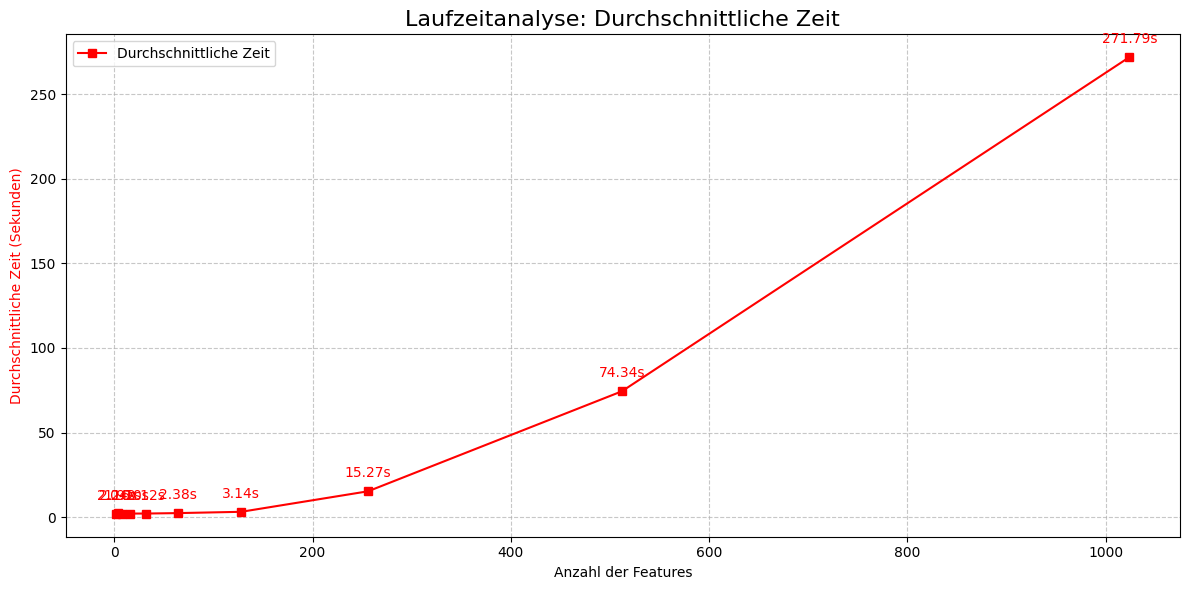

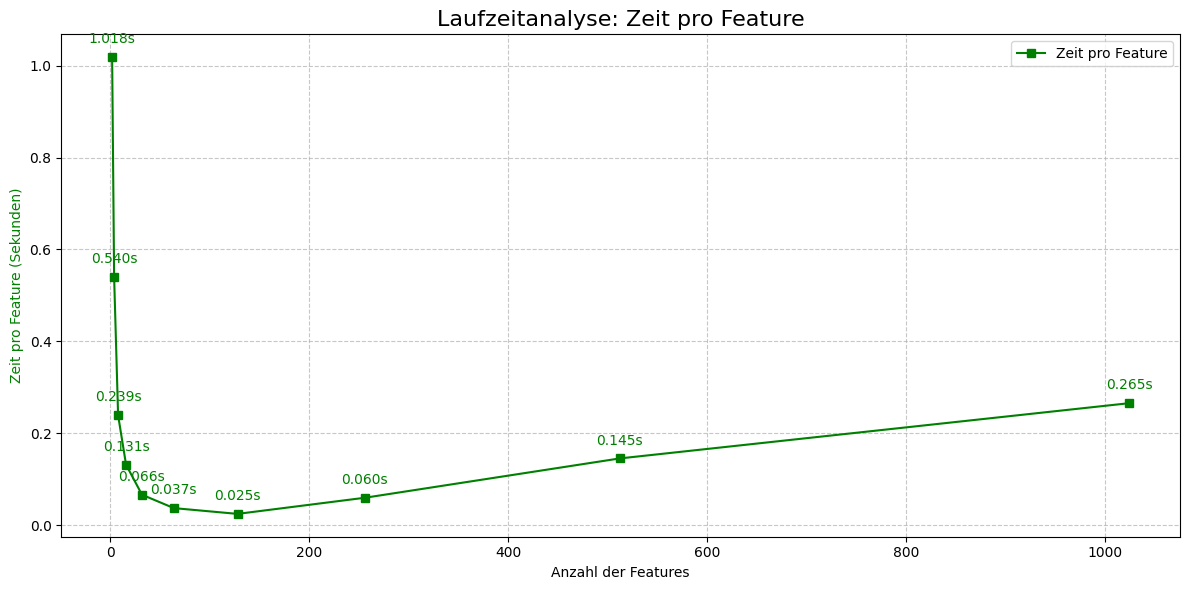

In [5]:
from pyspark.sql import SparkSession

#Hyperparameter
n_features_list = [2, 4, 8, 16, 32, 64 , 128, 256, 512, 1024]
n_rows = max(n_features_list) * 30
n_times = 3
n_workers = 4
    # Create Sparksession
spark = SparkSession.builder \
    .appName("Optimized-Cluster-Based-SVD-Regression") \
    .master("spark://spark-master:7077") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.default.parallelism", n_workers * 2) \
    .config("spark.sql.shuffle.partitions", n_workers * 2) \
    .config("spark.storage.memoryFraction", 0.8) \
    .config("spark.memory.fraction", 0.8) \
    .config("spark.executor.cores", 2) \
    .config("spark.task.cpus", 1) \
    .config("spark.rdd.compress", True) \
    .config("spark.broadcast.compress", True) \
    .config("spark.shuffle.compress", True) \
    .getOrCreate()

sc = spark.sparkContext

# run Performance Test
elapsed_times, avg_times, times_per_feature = run_performance_tests(
    n_features_list=n_features_list,
    n_rows=n_rows,
    n_times=n_times,
    n_workers=n_workers,
    sc=sc,
)